In [9]:
import gym
import gym_foa
from gym import wrappers



import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from collections import namedtuple
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import time
import os
import shutil

In [10]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

N = 5
EXPERIENCE_CAPACITY = 5000
MAX_EPI = 2*int(1e4)
LR_critic = .0001
BATCH_SIZE = 64

exp_name = 'init_bkrd_clr_{}_bs_{}_capa_{}k_epi_{}k_x{}'.format(\
            LR_critic, BATCH_SIZE, float(EXPERIENCE_CAPACITY)/1000., float(MAX_EPI)/1000., N)
#exp_name = 'test'
if os.path.exists(exp_name):
    shutil.rmtree(exp_name)
os.mkdir(exp_name)

ENV_NAME = 'foa-v0'
env = gym.make(ENV_NAME)
RECORD = True

if RECORD:
    #env = wrappers.Monitor(env, '{}/record'.format(exp_name), force=True, video_callable=lambda episode_id: True)
    env = wrappers.Monitor(env, '{}/record'.format(exp_name), force=True)
TAU = .01
GAMMA = .9
LR_actor = .001


TARGET_UPDATE_FREQUENCY = 200

MAX_STEP = 100

EPSILON = 1
EPSILON_DECAY = 1./(1e5)
N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.shape[0]
N_UAVS = 1
V_MAX = env.action_space.high[0]
print V_MAX

[2017-10-23 22:02:19,005] Making new env: foa-v0
[2017-10-23 22:02:19,836] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/linjt/foa/bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record')
[2017-10-23 22:02:19,845] Creating monitor directory init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record


5.0


In [11]:
# initialization
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

In [12]:
# classes
class Experience(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.mem = []
        self.pos = 0
    
    def push(self, o, a, r, o_next):
        if len(self.mem) < self.capacity:
            self.mem.append(None)
        self.mem[self.pos] = Transition(o, a, r, o_next)
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, size):
        return random.sample(self.mem, min(size, len(self.mem)))
        #return self.mem[:1]
    
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fcS = nn.Linear(N_STATES, 150)
        nn.init.kaiming_normal(self.fcS.weight)
        self.bnS = nn.BatchNorm1d(150)
        
        self.fcA = nn.Linear(N_ACTIONS, 150)
        nn.init.kaiming_normal(self.fcA.weight)
        self.bnA = nn.BatchNorm1d(150)
        
        self.fc1 = nn.Linear(150, 100)
        nn.init.kaiming_normal(self.fc1.weight)
        self.bn1 = nn.BatchNorm1d(100)
        
        self.fc2 = nn.Linear(100, 100)
        nn.init.kaiming_normal(self.fc2.weight)
        self.bn2 = nn.BatchNorm1d(100)
        
        self.fc3 = nn.Linear(100, 1)
        nn.init.kaiming_normal(self.fc3.weight)
    
    def forward(self, x, y):
#         s = (self.fcS(x))
#         a = (self.fcA(y))
#         o = F.relu(s+a)
#         o = (self.fc1(o))
#         o = F.relu(o)
#         o = (self.fc2(o))
        
        s = self.bnS(self.fcS(x))
        a = self.bnA(self.fcA(y))
        o = F.relu(s+a)
        o = self.bn1(self.fc1(o))
        o = F.relu(o)
        o = self.bn2(self.fc2(o))
        
        o = F.relu(o)
        o = self.fc3(o)
        return o

class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(N_STATES/N_UAVS, 150)
        nn.init.kaiming_normal(self.fc1.weight)
        self.bn1 = nn.BatchNorm1d(150)
        
        self.fc2 = nn.Linear(150, 100)
        nn.init.kaiming_normal(self.fc2.weight)
        self.bn2 = nn.BatchNorm1d(100)
        
        self.fc3 = nn.Linear(100, 100)
        nn.init.kaiming_normal(self.fc3.weight)
        self.bn3 = nn.BatchNorm1d(100)
        
        self.fc4 = nn.Linear(100, N_ACTIONS/N_UAVS)
        nn.init.kaiming_normal(self.fc4.weight)
        
    def forward(self, x):
#         x = (self.fc1(x))
#         x = F.relu(x)
#         x = (self.fc2(x))
#         x = F.relu(x)
#         x = (self.fc3(x))
        
        x = self.bn1(self.fc1(x))
        x = F.relu(x)
        x = self.bn2(self.fc2(x))
        x = F.relu(x)
        x = self.bn3(self.fc3(x))
        
        x = F.relu(x)
        x = self.fc4(x)
        x = F.tanh(x)
        return x

In [13]:
# [reference] https://github.com/matthiasplappert/keras-rl/blob/master/rl/random.py

class RandomProcess(object):
    def reset_states(self):
        pass

class AnnealedGaussianProcess(RandomProcess):
    def __init__(self, mu, sigma, sigma_min, n_steps_annealing):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma


# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckProcess(AnnealedGaussianProcess):
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=1000):
        super(OrnsteinUhlenbeckProcess, self).__init__(mu=mu, sigma=sigma, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.x0 = x0
        self.size = size
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros(self.size)

In [14]:
def map_to_v(a, low, high):
    return (low+high)/2 + a*(high-low)/2

def choose_action(state, actor, rand_proc=None):
    global epsilon
    a = actor(Variable(Tensor(state).unsqueeze(0))).data.cpu().numpy()[0].astype('float64')
    if rand_proc is not None:
        a += max(epsilon, 0)*rand_proc.sample()
    a = np.clip(a, -1., 1.)
    epsilon -= EPSILON_DECAY
    #print epsilon
    return a

def update_actor_critic(target_actor, target_critic, \
                       actor, critic, exp, optim_actor, optim_critic):
    
    
    
    # sample minibatch
    minibatch = Transition(*zip(*exp.sample(BATCH_SIZE)))
    bat_o = Variable(Tensor(minibatch.state))
    bat_a = Variable(Tensor(minibatch.action))
    bat_r = Variable(Tensor(minibatch.reward)).unsqueeze(1)
    bat_o_ = Variable(Tensor(minibatch.next_state))
    
    bat_a0_ = target_actor(bat_o_[:,:N_STATES/N_UAVS])
    #bat_a1_ = target_actor(bat_o_[:,N_STATES/N_UAVS:-N_STATES/N_UAVS])
    #bat_a2_ = target_actor(bat_o_[:,-N_STATES/N_UAVS:])
    #bat_a_o_ = torch.cat([bat_a0_, bat_a1_, bat_a2_], dim=1)
    bat_a_o_ = bat_a0_

    Gt = bat_r + GAMMA * target_critic(bat_o_, bat_a_o_)
    Gt.detach_()
    eval_o = critic(bat_o, bat_a)
    criterion = nn.MSELoss()
    if use_cuda:
        criterion.cuda()
    loss = criterion(eval_o, Gt)
    #optimizer = optim.Adam(critic.parameters(), lr=LR_critic)
    optim_critic.zero_grad()
    loss.backward()
    optim_critic.step()
    
    # update actor
    bat_a0 = actor(bat_o[:,:N_STATES/N_UAVS])
    #bat_a1 = actor(bat_o[:,N_STATES/N_UAVS:-N_STATES/N_UAVS])
    #bat_a2 = actor(bat_o[:,-N_STATES/N_UAVS:])
    #bat_a_o = torch.cat([bat_a0, bat_a1, bat_a2], dim=1)
    bat_a_o = bat_a0
    
    obj = torch.mean(critic(bat_o, bat_a_o))
    #optimizer = optim.Adam(actor.parameters(), lr=-LR_actor)
    optim_actor.zero_grad()
    obj.backward()
    optim_actor.step()    

def update_target(target_actor, target_critic, \
                         actor, critic):
    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())

def soft_update(target, behavior, tau):
    for key in target.state_dict().keys():
        target.state_dict()[key].copy_(tau * behavior.state_dict()[key] + (1-tau) * target.state_dict()[key])

In [15]:


n_vec_r = []
n_vec_avg_cost = []
n_vec_total_cost = []
n_vec_target_update = []
n_vec_experience_refresh = []
n_vec_training_time = []
for n in xrange(5):    
    start_time = time.time()
    
    target_actor = Actor()
    target_critic = Critic()
    actor = Actor()
    critic = Critic()
    if use_cuda:
        target_actor.cuda()
        target_critic.cuda()
        actor.cuda()
        critic.cuda()
    exp = Experience(EXPERIENCE_CAPACITY)
    optim_critic = optim.Adam(critic.parameters(), lr=LR_critic)
    optim_actor = optim.Adam(actor.parameters(), lr=-LR_actor)

    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())
    
    random_process = OrnsteinUhlenbeckProcess(\
            size=N_ACTIONS/N_UAVS, theta=.15, mu=0, sigma=.2)
    epsilon = EPSILON
    
    vec_r = []
    vec_avg_cost = []
    vec_total_cost = []
    vec_target_update = []
    vec_experience_refresh = []
    update_counter = 0
    for epi in xrange(MAX_EPI):
        if epi%(MAX_EPI/10)==0:
            print 'n:{}, epi:{}'.format(n, epi)
                    
        random_process.reset_states()
        
        o = env.reset()
        acc_r = 0
        
        local_r = []
        
        avg_cost = np.zeros([4])
        total_cost = 0
    
        counter = 0
        #for t in xrange(MAX_STEP):    
        while True:
            counter += 1
            
            if RECORD:
                env.render()
            
            a0 = choose_action(o[:N_STATES/N_UAVS], actor, random_process)
            #a1 = choose_action(o[N_STATES/N_UAVS:-N_STATES/N_UAVS], actor)
            #a2 = choose_action(o[-N_STATES/N_UAVS:], actor)
            #a = np.hstack([a0, a1, a2])
            a = a0
            if update_counter<1000:
                a = np.array([0.,3./5.])
            
            o_, r, done, info = env.step(map_to_v(a, -V_MAX, V_MAX))
            exp.push(o, a, r, o_)
            
            cost = np.array(info['cost'])
            avg_cost += (cost-avg_cost)/(counter)
            total_cost += r
            
            update_actor_critic(target_actor, target_critic, \
                               actor, critic, exp, optim_actor, optim_critic)
            update_counter += 1
            
            if update_counter % TARGET_UPDATE_FREQUENCY == 0:
                vec_target_update.append(epi)
                update_target(target_actor, target_critic, \
                             actor, critic)
            if update_counter % EXPERIENCE_CAPACITY == 0:
                vec_experience_refresh.append(epi)
            
            local_r.append(r)
            acc_r += r
            o = o_
            if done:
                break
        
        vec_r.append(acc_r)
        vec_avg_cost.append(avg_cost)
        vec_total_cost.append(total_cost)
        
    n_vec_r.append(vec_r)
    n_vec_avg_cost.append(vec_avg_cost)
    n_vec_total_cost.append(vec_total_cost)
    n_vec_target_update.append(vec_target_update)
    n_vec_experience_refresh.append(vec_experience_refresh)
    n_vec_training_time.append((time.time() - start_time)/60)
    
    torch.save(actor.state_dict(), '{}/actor{}.pt'.format(exp_name, n))
    
    print "--- {} minutes ---".format((time.time() - start_time)/60)



[2017-10-23 22:02:23,951] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video000000.mp4


n:0, epi:0


[2017-10-23 22:02:24,938] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video000001.mp4
[2017-10-23 22:02:27,887] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video000008.mp4
[2017-10-23 22:02:35,835] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video000027.mp4
[2017-10-23 22:02:51,035] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video000064.mp4
[2017-10-23 22:03:24,956] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video000125.mp4
[2017-10-23 22:04:09,260] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_ca

n:0, epi:2000


[2017-10-23 22:45:50,383] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video003000.mp4
[2017-10-23 22:51:12,501] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video004000.mp4


n:0, epi:4000


[2017-10-23 22:57:51,295] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video005000.mp4
[2017-10-23 23:02:34,313] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video006000.mp4


n:0, epi:6000


[2017-10-23 23:06:29,768] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video007000.mp4
[2017-10-23 23:10:27,674] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video008000.mp4


n:0, epi:8000


[2017-10-23 23:14:30,876] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video009000.mp4
[2017-10-23 23:20:05,897] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video010000.mp4


n:0, epi:10000


[2017-10-23 23:25:45,232] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video011000.mp4
[2017-10-23 23:31:37,485] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video012000.mp4


n:0, epi:12000


[2017-10-23 23:36:54,335] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video013000.mp4
[2017-10-23 23:42:43,088] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video014000.mp4


n:0, epi:14000


[2017-10-23 23:48:32,621] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video015000.mp4
[2017-10-23 23:53:47,767] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video016000.mp4


n:0, epi:16000


[2017-10-23 23:59:38,967] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video017000.mp4
[2017-10-24 00:05:03,778] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video018000.mp4


n:0, epi:18000


[2017-10-24 00:10:50,587] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video019000.mp4
[2017-10-24 00:16:45,369] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video020000.mp4


--- 134.3567548 minutes ---
n:1, epi:0


[2017-10-24 00:30:28,874] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video021000.mp4
[2017-10-24 00:42:21,316] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video022000.mp4


n:1, epi:2000


[2017-10-24 01:00:44,891] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video023000.mp4
[2017-10-24 01:11:51,100] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video024000.mp4


n:1, epi:4000


[2017-10-24 01:20:32,229] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video025000.mp4
[2017-10-24 01:25:41,894] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video026000.mp4


n:1, epi:6000


[2017-10-24 01:29:34,996] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video027000.mp4
[2017-10-24 01:33:31,956] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video028000.mp4


n:1, epi:8000


[2017-10-24 01:36:55,974] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video029000.mp4
[2017-10-24 01:40:53,106] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video030000.mp4


n:1, epi:10000


[2017-10-24 01:44:51,290] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video031000.mp4
[2017-10-24 01:48:40,106] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video032000.mp4


n:1, epi:12000


[2017-10-24 01:52:08,417] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video033000.mp4
[2017-10-24 01:56:07,442] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video034000.mp4


n:1, epi:14000


[2017-10-24 02:00:06,000] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video035000.mp4
[2017-10-24 02:03:41,186] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video036000.mp4


n:1, epi:16000


[2017-10-24 02:07:32,411] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video037000.mp4
[2017-10-24 02:11:27,631] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video038000.mp4


n:1, epi:18000


[2017-10-24 02:15:21,686] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video039000.mp4
[2017-10-24 02:18:53,529] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video040000.mp4


--- 122.136217586 minutes ---
n:2, epi:0


[2017-10-24 02:29:46,740] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video041000.mp4
[2017-10-24 02:37:21,455] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video042000.mp4


n:2, epi:2000


[2017-10-24 02:43:23,517] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video043000.mp4
[2017-10-24 02:48:59,676] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video044000.mp4


n:2, epi:4000


[2017-10-24 02:55:55,985] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video045000.mp4
[2017-10-24 03:02:05,038] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video046000.mp4


n:2, epi:6000


[2017-10-24 03:09:23,708] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video047000.mp4
[2017-10-24 03:24:41,383] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video048000.mp4


n:2, epi:8000


[2017-10-24 03:38:50,755] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video049000.mp4
[2017-10-24 03:46:19,784] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video050000.mp4


n:2, epi:10000


[2017-10-24 03:57:12,828] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video051000.mp4
[2017-10-24 04:05:33,928] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video052000.mp4


n:2, epi:12000


[2017-10-24 04:13:06,387] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video053000.mp4
[2017-10-24 04:19:23,670] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video054000.mp4


n:2, epi:14000


[2017-10-24 04:21:42,803] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video055000.mp4
[2017-10-24 04:23:31,497] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video056000.mp4


n:2, epi:16000


[2017-10-24 04:25:28,154] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video057000.mp4
[2017-10-24 04:27:17,189] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video058000.mp4


n:2, epi:18000


[2017-10-24 04:29:04,299] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video059000.mp4
[2017-10-24 04:30:49,609] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video060000.mp4


--- 131.934940068 minutes ---
n:3, epi:0


[2017-10-24 04:34:18,826] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video061000.mp4
[2017-10-24 04:36:55,930] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video062000.mp4


n:3, epi:2000


[2017-10-24 04:39:48,509] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video063000.mp4
[2017-10-24 04:42:25,145] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video064000.mp4


n:3, epi:4000


[2017-10-24 04:44:19,757] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video065000.mp4
[2017-10-24 04:45:32,616] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video066000.mp4


n:3, epi:6000


[2017-10-24 04:47:06,284] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video067000.mp4
[2017-10-24 04:49:17,505] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video068000.mp4


n:3, epi:8000


[2017-10-24 04:51:04,964] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video069000.mp4
[2017-10-24 04:52:51,695] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video070000.mp4


n:3, epi:10000


[2017-10-24 04:54:35,421] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video071000.mp4
[2017-10-24 04:56:22,973] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video072000.mp4


n:3, epi:12000


[2017-10-24 04:58:09,873] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video073000.mp4
[2017-10-24 04:59:53,481] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video074000.mp4


n:3, epi:14000


[2017-10-24 05:01:38,259] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video075000.mp4
[2017-10-24 05:03:29,229] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video076000.mp4


n:3, epi:16000


[2017-10-24 05:05:44,493] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video077000.mp4
[2017-10-24 05:08:02,257] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video078000.mp4


n:3, epi:18000


[2017-10-24 05:10:24,183] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video079000.mp4
[2017-10-24 05:12:42,954] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video080000.mp4


--- 41.8890789668 minutes ---
n:4, epi:0


[2017-10-24 05:17:44,334] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video081000.mp4
[2017-10-24 05:21:54,161] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video082000.mp4


n:4, epi:2000


[2017-10-24 05:25:34,547] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video083000.mp4
[2017-10-24 05:29:35,548] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video084000.mp4


n:4, epi:4000


[2017-10-24 05:32:14,173] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video085000.mp4
[2017-10-24 05:34:16,866] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video086000.mp4


n:4, epi:6000


[2017-10-24 05:36:49,287] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video087000.mp4
[2017-10-24 05:42:08,929] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video088000.mp4


n:4, epi:8000


[2017-10-24 05:46:28,840] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video089000.mp4
[2017-10-24 05:53:22,387] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video090000.mp4


n:4, epi:10000


[2017-10-24 05:58:44,282] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video091000.mp4
[2017-10-24 05:59:56,058] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video092000.mp4


n:4, epi:12000


[2017-10-24 06:01:06,577] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video093000.mp4
[2017-10-24 06:02:23,425] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video094000.mp4


n:4, epi:14000


[2017-10-24 06:03:41,677] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video095000.mp4
[2017-10-24 06:04:52,994] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video096000.mp4


n:4, epi:16000


[2017-10-24 06:06:08,608] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video097000.mp4
[2017-10-24 06:07:23,174] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video098000.mp4


n:4, epi:18000


[2017-10-24 06:08:37,410] Starting new video recorder writing to /home/linjt/foa/init_bkrd_clr_0.0001_bs_64_capa_5.0k_epi_20.0k_x5/record/openaigym.video.1.12488.video099000.mp4


--- 57.1314777652 minutes ---


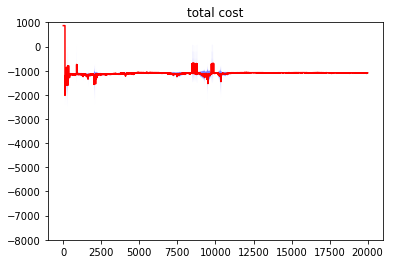

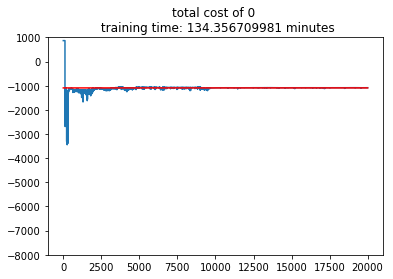

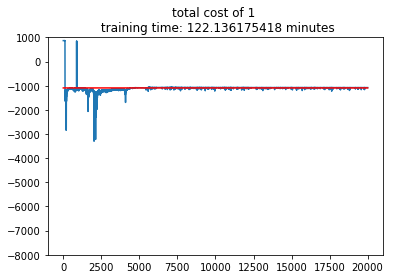

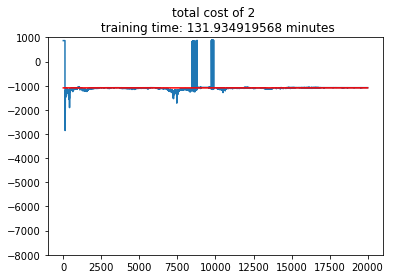

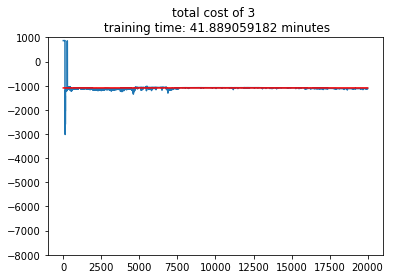

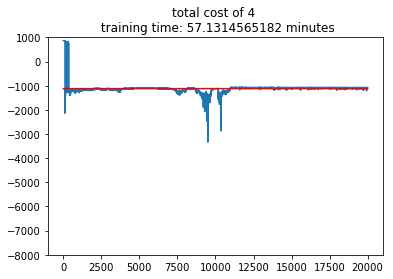

In [16]:
def plot_avg_1d(vec, title=None, xlabel=None, ylabel=None, save=False, folder='.',\
                ylim=None, begin=0, marker='', target=None, exp=None):
    record = np.array(vec)
    if len(record.shape) is not 1:
        print 'vec should be 1D array [e0, e1, ...]'
        return
    if ylim is not None:
        axes = plt.gca()
        axes.set_ylim(ylim)
    mu = record.mean(axis=0)
    plt.plot(np.array(range(record.shape[0]))+begin, record, marker)
    plt.plot(np.array(range(record.shape[0]))+begin, mu*np.ones(record.shape[0]), color='red')
    patches = []
    if target is not None and len(target)>0:
        target = np.array(target)
        target_color = 'b'
        target_patch = mpatches.Patch(color=target_color, label='update target')
        patches.append(target_patch)
        for t in target:
            plt.axvline(t, ls='dashed', c=target_color)
    if exp is not None and len(exp)>0:
        exp = np.array(exp)
        exp_color = 'r'
        exp_patch = mpatches.Patch(color=exp_color, label='exp refresh')
        patches.append(exp_patch)
        for e in exp:
            plt.axvline(e, ls='dashed', c=exp_color)
    if len(patches)>0:
        plt.legend(handles=patches)
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel, rotation=45)
    if save:
        plt.savefig('{}/{}.png'.format(folder, title))      
    plt.show()

def plot_avg_2d(vec, title=None, xlabel=None, ylabel=None, save=False, folder='.',\
                ylim=None, begin=0):
    record = np.array(vec)
    if len(record.shape) is not 2:
        print 'vec should be 2D array [[seq0], [seq1], ...]'
        return
    if ylim is not None:
        axes = plt.gca()
        axes.set_ylim(ylim)
    mu = record.mean(axis=0)
    sigma = record.std(axis=0)
    lower_bound = mu-sigma
    upper_bound = mu+sigma
    plt.plot(np.array(range(mu.shape[0]))+begin, mu, color='red')
    plt.fill_between(np.array(range(mu.shape[0]))+begin, lower_bound, upper_bound, facecolor='blue', alpha=0.5)
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel, rotation=45)
    if save:
        plt.savefig('{}/{}.png'.format(folder, title))
    plt.show()

# data
n_vec_avg_cost = np.array(n_vec_avg_cost)
n_vec_total_cost = np.array(n_vec_total_cost)
n_vec_target_update = np.array(n_vec_target_update)
n_vec_experience_refresh = np.array(n_vec_experience_refresh)


cost = gym_foa.envs.FoaEnv.Cost(*np.rollaxis(n_vec_avg_cost,2))
avg_cost = cost.collision[0]+cost.goal[0]+cost.formation[0]+cost.v_pref[0]

# param
save = True
marker = '.'

target = np.array([10,20,30])
experience = np.array([15,25])

plot_avg_2d(n_vec_total_cost, title='total cost', ylim=[-8000,1000], save=save, folder=exp_name)
for i in xrange(n_vec_avg_cost.shape[0]):
    plot_avg_1d(n_vec_total_cost[i], title='total cost of {} \n training time: {} minutes'.format(i, n_vec_training_time[i]),\
                ylim=[-8000,1000], save=save, folder=exp_name)
                #target=n_vec_target_update[i], )
                #exp=n_vec_experience_refresh[i])



# marker = ''
# int0 = slice(0,20000)
# # plot_avg_1d(n_vec_total_cost[0][int0], title='total cost: first drop', ylim=[-8000,1000], begin=int0.start, save=save, marker=marker)
# plot_avg_1d(cost.v_pref[0][int0], title='v_pref: first drop', begin=int0.start, save=save, marker=marker)

# marker = ''
# int1 = slice(3000,3200)
# plot_avg_1d(n_vec_total_cost[0][int1], title='total cost: second drop', ylim=[-8000,1000], begin=int1.start, save=save, marker=marker)
# plot_avg_1d(cost.v_pref[0][int1], title='v_pref: second drop', begin=int1.start, save=save, marker=marker)

# int2 = slice(7000,8000)
# plot_avg_1d(n_vec_total_cost[0][int2], title='total cost: second drop', ylim=[-8000,1000], begin=int2.start, save=save, marker=marker)
# plot_avg_1d(cost.v_pref[0][int2], title='v_pref: second drop', begin=int2.start, save=save, marker=marker)

# int3 = slice(9600,10000)
# plot_avg_1d(n_vec_total_cost[0][int3], title='total cost: third drop', ylim=[-8000,1000], begin=int3.start, save=save, marker=marker)
# plot_avg_1d(cost.v_pref[0][int3], title='v_pref: third drop', begin=int3.start, save=save, marker=marker)            
            

In [215]:
#torch.save(actor.state_dict(), 'actor_3w.param')
#torch.save(critic.state_dict(), 'critic.param')

#from gym import wrappers

#env = wrappers.Monitor(env, 'exp', force=True)


actor = Actor()
actor.load_state_dict(torch.load('actor3.pt'))
actor.eval()
#actor.cuda()

start_time = time.time()
counter = 0
for n in xrange(10):
    o = env.reset()
    for t in xrange(MAX_STEP):
        counter += 1
#        print 'n:{}, t:{}'.format(n, t)
#         env.render()
        #a0 = choose_action(o[:N_STATES/N_UAVS], actor)
        
        
        a0 = actor(Variable(torch.FloatTensor(o[:N_STATES/N_UAVS]).unsqueeze(0))).data.cpu().numpy()[0].astype('float64')
        
        
        #a1 = choose_action(o[N_STATES/N_UAVS:-N_STATES/N_UAVS], actor)
        #a2 = choose_action(o[-N_STATES/N_UAVS:], actor)
        #a = np.hstack([a0, a1, a2])
        
#        print a0
        
        o_, r, done, info = env.step(a0)
    
        o = o_
        if done:
            break
(time.time() - start_time)/counter

0.020631469999040877

In [245]:
import pickle

name = 'capa_7.5k_epi_2w_x5'

# Saving the objects:
with open('{}_total_cost.pickle'.format(name), 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump(n_vec_total_cost, f)

with open('{}_target_update.pickle'.format(name), 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump(n_vec_target_update, f)

with open('{}_experience_refresh.pickle'.format(name), 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump(n_vec_experience_refresh, f)
    
    
## Getting back the objects:
#with open('objs.pickle') as f:  # Python 3: open(..., 'rb')
#    k = pickle.load(f)
    
#print cost

In [71]:
x = np.array(range(10)).reshape(2,-1)
s = slice(None,2)
print s.step

None
